## Gaussian Mixture Model
Modify the scratch code of gaussian mixture clustering in our lecture:
- Modify so it performs early stopping when the log likelihood does not improve anymore. Note that if you log the normal distribution, you will get negative sign. Thus if you ignore the negative sign, it will become negative likelihood, and thus will get smaller and smaller.
- Perform plotting every 5 iterations on the resulting clusters.
---


**Coding considerations**

- To ease our programming efforts, we can use scipy.stats.multivariate_normal for generating gaussian distribution, and using its .pdf() function to compute the values we want of $N(x_i \mid \mu_k, \Sigma_k)$
- Shape of $r$ which keeps probability of $x^{(i)}$ belonging to $k$th cluster is $(m * k)$, where m is X.shape[0] and $k$ is number of clusters we want.
- Shape of $\Sigma$ or covariance of each cluster is simply $(n * n)$ where n is number of features or X.shape[1]. If we define 3 clusters, then we will have [$\Sigma_1$, $\Sigma_2$, $\Sigma_3$], each with shape $(n * n)$, thus whole thing is shape $ (k * n * n) $
- Shape of $\pi$ is simply $(k, )$
- Shape of $\mu$ is $(n, k)$, defining mean for each feature for $k$th cluster
-What to initialize can be tricky. For $r$ and $\pi$, you can fill with $1/k$. As for $\mu$, it is easiest to simply pick random points from the samples as initial means. Last, for covariance ($\Sigma$), we can simply use the covariance of the $X$ as initialization (i.e., np.cov(X.T))

0 iterations, log likelihood : 38797.33675351386, with difference of 38797.33675351386
1 iterations, log likelihood : 43479.10245709606, with difference of 4681.765703582198
2 iterations, log likelihood : 87032.39488393062, with difference of 43553.29242683457
3 iterations, log likelihood : 164379.19128258002, with difference of 77346.7963986494
4 iterations, log likelihood : 472776.965328806, with difference of 308397.774046226
5 iterations, log likelihood : 628802.5035186533, with difference of 156025.5381898473
6 iterations, log likelihood : 637462.2216375121, with difference of 8659.718118858756
7 iterations, log likelihood : 639801.0074266668, with difference of 2338.785789154703
8 iterations, log likelihood : 640503.0155152867, with difference of 702.0080886199139
9 iterations, log likelihood : 640736.5770704651, with difference of 233.56155517837033
10 iterations, log likelihood : 640818.1880895881, with difference of 81.61101912299637
11 iterations, log likelihood : 640847.2548

Text(0.5, 1.0, 'Final')

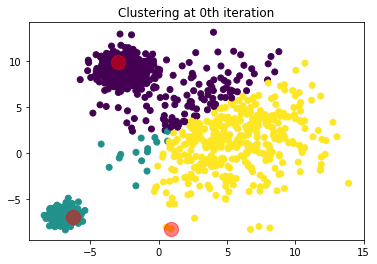

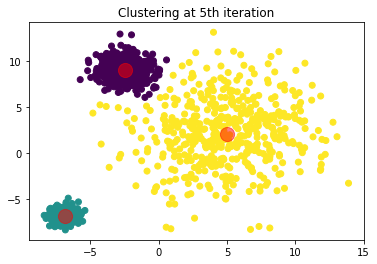

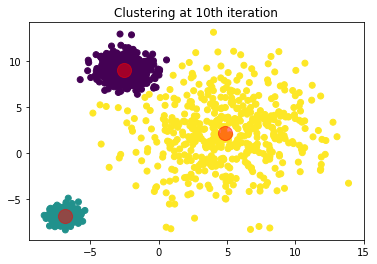

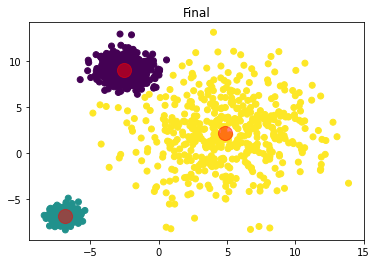

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
import math

X, y = make_blobs(n_samples=1500, cluster_std=[1.0, 3.5, 0.5], random_state=42)

#define basic params
m, n = X.shape
K = 3
max_iter = 50

#==initialization==

#responsibliity
r = np.full(shape=(m, K), fill_value=1/K)

#pi
pi = np.full((K, ), fill_value=1/K) #simply use 1/k for pi

#mean
random_row = np.random.randint(low=0, high=m, size=K)
mean = np.array([X[idx,:] for idx in random_row ]).T #.T to make to shape (M, K)

#covariance
cov = np.array([np.cov(X.T) for _ in range (K)])
previous_NLL = 0
NLL_diff_record = []

for iteration in range(max_iter):

    NLL = 0 #NLL > Negative Log Likelihood

    #===E-Step=====
    #Update r_ik of each sample
    for i in range(m):
        for k in range(K):
            xi_pdf = multivariate_normal.pdf(X[i], mean=mean[:, k], cov=cov[k])

            r[i, k] = pi[k] * xi_pdf
            NLL += math.log(pi[k])
            NLL += multivariate_normal.logpdf(X[i], mean=mean[:, k], cov=cov[k])
          
        r[i] /= np.sum(r[i])
    # print(r)
    # print(NLL)

    if math.fabs(NLL - previous_NLL) <5:
        print(f" The final iteration: {iteration} wit log likelihood : {np.abs(NLL)}, and with difference of {math.fabs(NLL - previous_NLL)}")
        break
    else:
        print(f"{iteration} iterations, log likelihood : {np.abs(NLL)}, with difference of {math.fabs(NLL - previous_NLL)}")
        NLL_diff_record.append(math.fabs(NLL - previous_NLL))
    previous_NLL = NLL



    if iteration %5 ==0 :
        yhat = np.argmax(r, axis = 1)
        plt.figure()
        plt.scatter(X[:, 0], X[:, 1], c=yhat)
        plt.scatter(mean.T[:, 0], mean.T[:, 1], c='red', s=200, alpha=0.5);
        plt.title(f"Clustering at {iteration}th iteration")



    #===M-Step====
    # Find NK first for latter use
    NK = np.sum(r, axis=0)
    assert NK.shape == (K, )
    
    #PI
    pi = NK / m
    assert pi.shape == (K, )
    
    #mean
    mean =  ( X.T @ r ) / NK
    assert mean.shape == (n, K)
    
    #covariance (also called Sigma)
    cov = np.zeros((K, n, n))
    for k in range(K):
        for i in range(m):
            X_mean = (X[i]-mean[:, k]).reshape(-1, 1)
            cov[k] += r[i, k] * (X_mean @ X_mean.T)
        cov[k] /= NK[k]
    assert cov.shape == (K, n, n)
        

#get preds
yhat = np.argmax(r, axis=1)
print(yhat)

#plot
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=yhat)
plt.scatter(mean.T[:, 0], mean.T[:, 1], c='red', s=200, alpha=0.5);
plt.title("Final")

Text(0, 0.5, 'the log likelihood\n difference from previous iteration')

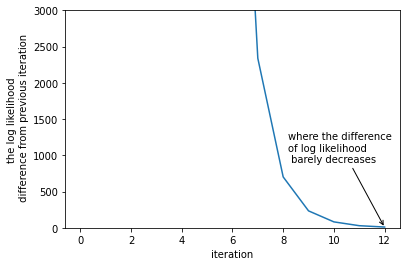

In [5]:
plt.plot(np.arange(len(NLL_diff_record)), NLL_diff_record)
plt.ylim(0,3000)
plt.annotate('where the difference \nof log likelihood\n barely decreases', xy=(12, 5), xytext=(8.2, 900),  #xytext ---> xy
            arrowprops=dict(arrowstyle="->"))
plt.xlabel('iteration')
plt.ylabel('the log likelihood\n difference from previous iteration')

---
## SUMMARY
- The GMM models is better at classifying data with different gaussian distribution, rather than assuming that every cluster has the same spherical shape (the same mean and standard deviation)
- Using early stop, the model can finish when the log likelihood changes is smaller than the threhold (5 for this example)
